#Function Approximation in RL
In this report we will implement the method of Kernel Based Reinforcement Learning (kbrl) as explained in [Ormoneit and Sen (2002)](https://link.springer.com/article/10.1023%2FA%3A1017928328829) using a nearest neighbor measure where the neighbors are weighted via a Gaussian Kernel. The report has 2 main sections:

1.   **Function Development:**  In this section we will develop the main functions that will aid us implement the kbrl.
2.   **Algorithm Testing:** In this section we will test our kbrl algorithm on 2 continuous tasks in the Gym environments. These tasks are:

  1.   The CartPole problem
  2.   The Acrobot problem





## 1.  Function Development





In [0]:
! pip install gym

In [0]:
import random
import sys
import os
import numpy as np
import gym
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

### 1.1  Kernel based Nearest Neighbor 
The following function is our base function for the nearest neighbor kernel calculations. This is a Gaussian kernel that calculates the weights of the neighbors of $(x)$ via the following formula:
$$K(x',x)=\exp\Big(-\frac{\|x'-x\|^2}{2\sigma^2}\Big)$$
The value of $\sigma$ is specified via the argument $(bandwidth)$. The parameter $(S)$ is the set of points we are considering to find the kernel values of $(x)$ with. Once, these values are obtained using the above formula, we will normalize them by the sum of all such values. Note that in this method the nearest neighbors of $(x)$ will obtain a heavier weight in comparison to the neighbors with greater distance. 

### 1.2  Value Iteration Update Rule
In order to form the value iteration mentioned in [Ormoneit and Sen (2002)](https://link.springer.com/article/10.1023%2FA%3A1017928328829) in equation $(5)$ we need to first compute or form the tensor $\Theta$. The following 2 functions are defined to just do that! The function $(o\_per\_action)$ is a helper function to make the function $(o\_complete\_calculat)$ more readable. 

*   $o\_per\_action$: Computes a matrix of kernel values for two matrices $(x)$ and $(y)$ with a specified $(bandwidth)$. Matrices $(x)$ and $(y)$ are the set of all observed transitions for a specific action, where $(x)$ is the start of the transition and $(y)$ is the end of the said transition.

*   $o\_complete\_calculate$: Computes the tensor $\Theta$ given a $(bandwidth)$ and an input data consisting of all observed transitions for all actions $(data\_tensor)$. This function repeatedly calls $(o\_per\_action)$ in order to compute the kernel for all actions or in another words the tensor $\Theta$. 



In [0]:
def nn_kernel(S,x,bandwdith):
  #x: must be a row vector
  #S: each row is a point
  m,_=S.shape #m is the number of points in S
  weights=np.exp(np.power(np.linalg.norm(S-x,axis=1)/bandwdith, 2)/(-2))
  weights=weights/np.sum(weights)
  return weights  

In [0]:
def o_per_action(x,y,bandwidth):
  '''
  #x: is the begin state of the set of m transitions for an specific action
  #y: is the corresponding end state of the the set of m transtions for the 
  same action
  The output is the kernel computed for y vs x where the location (s',s) 
  corresponds to K(xs,ys')
  '''
  m,_=x.shape
  kernel_output=np.zeros([m,m])
  for i in range(m):
    kernel_output[i,:]=nn_kernel(x,y[i],bandwidth)
  return kernel_output

In [0]:
def o_complete_calculate(data_tensor,bandwidth):
  '''
  The "data_tensor" is an mxMx2xn where m is the number of transitions,
  M is the number of actions, 2 indicates that in each mxM there will be 2
  vectors, one x and one y. 'n' here indicates the dimensions of the vectors x 
  and y.
  '''
  m,M,_,_=data_tensor.shape
  output_o=np.zeros([m,M,m])
  for i in range(M):
    output_o[:,i,:]=o_per_action(data_tensor[:,i,0,:],data_tensor[:,i,1,:],bandwidth)
  return output_o

### 1.3  Data Manipulation
The function $(data\_manipulation)$ does the needed data manipulation to prepare the needed input parameters for the function ($best\_action\_kbrl$) which we will later use to test out our policy.

In [0]:
def data_manipulation(bandwidth,gamma,number_iterations,data_tensor,R):
  O=o_complete_calculate(data_tensor,bandwidth)
  J=kbrl_table(R,O,gamma,number_iterations)
  return O,J

### 1.4  Best Action Estimator
The following function will estimate the best action to take when a new state $(x)$ is observed. The output is based on the kbrl method and the equation $(3)$ of the paper by [Ormoneit and Sen (2002)](https://link.springer.com/article/10.1023%2FA%3A1017928328829).

In [0]:
def best_action_kbrl(J,R,data_tensor,gamma,bandwidth,x):
  #J: Is the mxM value matrix found from the equation (5) of the paper. The function that computes this matrix in this paper is called kbrl_table
  #R: Is the mxM return matrix, R is provided from sampling data from the environment
  #data_tensor, bandwidth: Same as before
  #gamma: is the discount factor
  m,M=J.shape
  kernel_x=np.zeros([m,M])
  for i in range(M):
    kernel_x[:,i]=nn_kernel(data_tensor[:,i,0,:],x,bandwidth)
  temp=np.multiply(kernel_x,R+gamma*J)
  temp=np.sum(temp,axis=0)
  best_action=np.argmax(temp)
  return best_action

### 1.5  kbrl_table:
This function calculates an estimate of $(J)$ as it is indicated by equation (5) of the paper. For its inputs, it requires the number of iterations we would like it to iterate for $(number\_iterations)$ as well as the reward matrix $(R)$ and the tensor $\Theta$.

In [0]:
def kbrl_table(R,O,gamma,number_iterations):
  #gamma: discount_rate
  #R: mxM reward matrix with r(ys^a,xs,a) at (s,a)
  #O: m×M×m tensor with entry k(xs,ys'^a) at location (s',a,s)
  J_old=np.zeros(R.shape)
  for i in range(number_iterations):
    J_new=np.tensordot(O,R+gamma*J_old,axes=1)
    J_new=np.amax(J_new,1) #taking the maximum over the second axes
    J_old=J_new
  return J_new    

## 2.  Algorithm Testing

### 2.1 First Environemnt: The CartPole problem
>"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center." 

*Taken from: [Gym Environments Documentations](https://gym.openai.com/envs/CartPole-v1/)*

#### 2.1.1 Sample Transition Collection
Below we will collect $(m)$ sample transitions for each actions in this problem. Note that the we have only 2 actions to be concerned with in this problem. To collect the data we will let the environment progress while taking random actions, then we record the transitions we observe. We stop collecting data once we have $(m)$ samples for each of the actions.

In [66]:
env = gym.make('CartPole-v0')
number_of_actions=2 #As mentioned above in this environmnet we only have 2 actions to take
m=1000 # number of sample transitions per actions
action_0=0 #number of times action(0) has been taken
action_1=0 #number of times action(1) has been taken
state_dimension=4 # This is the dimensions of the states, for this environment each state has 4 features
data_tensor_CartPole=np.zeros([m,number_of_actions,2,state_dimension])
R_CartPole=np.zeros([m,number_of_actions])
avg=0#stores an average number of steps that the environment can go on without the pendulum falling while taking random actions
i=1#store the total number of episodes that the environment will be simulated
while action_0<m or action_1<m:
  observation_x = env.reset()#observation_x is the start state of a transition
 # print('Episod: ',i)
  for t in range(100):
    action = env.action_space.sample()#taking random action
    observation_y, reward, done, info = env.step(action)
    #observation_y is the end of a transition
    if action==0 and action_0<m:
      data_tensor_CartPole[action_0,action,0,:]=observation_x
      data_tensor_CartPole[action_0,action,1,:]=observation_y
      R_CartPole[action_0,action]=reward
      action_0=action_0+1
      observation_x=observation_y
    if action==1 and action_1<m:
      data_tensor_CartPole[action_1,action,0,:]=observation_x
      data_tensor_CartPole[action_1,action,1,:]=observation_y
      R_CartPole[action_1,1]=reward
      action_1=action_1+1
      observation_x=observation_y
    if done:
      #print('Episode ',i, " finished after {} timesteps".format(t+1))
      if action==0:
        R_CartPole[action_0-1,action]=0
      if action==1:
        R_CartPole[action_1-1,action]=0
      avg=avg+t+1
      break
  i=i+1
Random_Avg_CartPole=avg/(i-1)  
print('The average number of steps taken randomly before the pendulum falls is: ',Random_Avg_CartPole)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
The average number of steps taken randomly before the pendulum falls is:  19.798076923076923


#### 2.1.2  Our Optimal Policy for CartPole Problem

##### 2.1.2.1 Test of The Policy on Cartpole Problem
The function $(test\_CartPole)$ simulates the CartPole problem with a given policy and the relevant parameters. It runs the simulation for $(number\_episodes\_test)$ which we are setting it to 1000 and then averages the result to find the average number of steps that our algorithm can make while not letting the pendulum to fall.

In [0]:
def test_CartPole (O,J,R,data_tensor,gamma,bandwidth,number_episodes_test=1000):
  env = gym.make('CartPole-v0')
  average_episodes=0
  for episodes in range(number_episodes_test):
    state_test = env.reset()
    for time in range(1000):
      action=best_action_kbrl(J,R,data_tensor,gamma,bandwidth,state_test)
      state_test,_,done,_=env.step(action)
      if done:
        #print("Episode finished after {} timesteps".format(time+1))
        average_episodes=average_episodes+time+1
        break
  average_episodes=average_episodes/number_episodes_test
  return average_episodes

##### 2.1.2.2  Results of the Algorithm for CartPole Problem
Below we will compare how well the algorithm performs for a selected values of $(bandwidth)$ and $(gamma)$.

In [0]:
plt.close()
bandwidth_set=np.array([0.01,0.02,0.03,0.04,0.05,0.06])
random_plot_avg=np.zeros([1,bandwidth_set.size])+Random_Avg_CartPole
gamma_set=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
number_iterations=50
for i in range(gamma_set.size):
  average_test_run=np.zeros(bandwidth_set.size)
  for j in range (bandwidth_set.size):
    O,J=data_manipulation(bandwidth_set[j],gamma_set[i],number_iterations,data_tensor_CartPole,R_CartPole)
    average_test_run[j]=test_CartPole (O,J,R_CartPole,data_tensor_CartPole,gamma_set[i],bandwidth_set[j])
  plt.plot(bandwidth_set.flatten(),average_test_run.flatten(),label="gamma={}".format(gamma_set[i]),color=(random.random(),random.random(),random.random()))
plt.plot(bandwidth_set.flatten(),random_plot_avg.flatten(),label="Random",color=(1,0,0))  
plt.legend()
plt.xlabel('Bandwidth Value')
plt.ylabel('Average Time Before The Pendulum Falls')
plt.show()


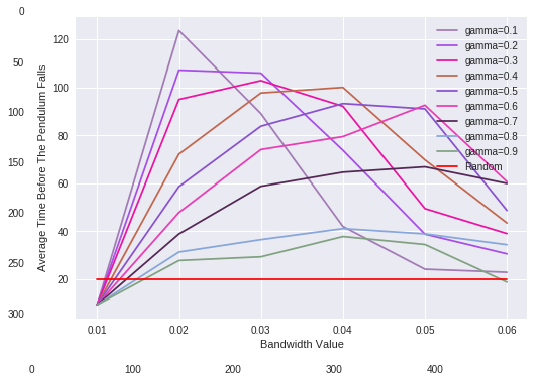

In [12]:
import matplotlib.pyplot as plt
avg_time_vs_bandwidth=plt.imread("avg_time_vs_bandwidth.png");
plt.figure(figsize=(9,9))
plt.grid(False);
plt.imshow(avg_time_vs_bandwidth);

#### 2.1.3  Conculusion 
We can see from the graph above that the optimal policy happened for the $(bandwidth)$ value of $0.02$ and $(gamma)$ of $0.1$. In our experiments with the problem, we observed that the pair of optimal values of $(bandwidth)$ and $(gamma)$ depends on the number of sample transitions. Note that a large $(bandwidth)$ leads to a very smooth density distribution (i.e. high bias) and a small $(bandwidth)$ leads to a not so smooth (i.e. high variance) density distribution.

The other observation we made is that the performance increases with more sample transitions we have, here we only chose $1000$ sample transition per action and the result already confirms the benefit of our algorithm. We chose $1000$ as it is a significant number for samples to have and it let us obtain the above graph in a reasonable amount of time. However to observe better performance we suggest choosing a bigger sample size. Note that choosing a bigger sample size, however, will lead to a different optimal pair of $(gamma)$ and $(bandwidth)$ values, as mentioned before.

Note that this algorithm will not provide the CartPole Problem with a solution capable of balancing the pendulum forever. The pendulum will eventually fall, however this fall can be delayed if we choose to have more samples. This is because by choosing the actions randomly we are not going to have the chance to explore/sample fully the interval of the observable states. As a result once we observe those states that are very far from any points we have sampled, the algorithm will not be able to perform optimally. To fix this issue, we suggest to either increase the sample size (as mentioned before) or to sample the states more efficiently (as opposed to random) so that our samples would to some extent cover the interval of the observable states.


### 2.2  Second Environemnt: The Acrobot Probelm
>"The acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height."

*Taken from: [Gym Environmnets Documentations](https://gym.openai.com/envs/Acrobot-v1/)*

#### 2.2.1  Sample Transition Collection
Below we will collect $(m)$ sample transitions for each actions in this problem. Note that the we have only $3$ actions to be concerned with in this problem. To collect the data we will let the environment progress while taking random actions, then we record the transitions we observe. We stop collecting data once we have $(m)$ samples for each of the actions.

In [304]:
env = gym.make("Acrobot-v1").env
m=5000#Total number of smaple transitions to be collected for each action
action_0=0#number of times action(0) has been taken
action_1=0#number of times action(1) has been taken
action_2=0#number of times action(2) has been taken
number_actions=3#total number of actions, as mentioned above
state_dimension=6 # This is the dimensions of the states, for this environment each state has 6 features
avg_steps_Acro=0#To compute the average needed steps while acting randomly to reach the goal in Acrobot
data_tensor_Acro=np.zeros([m,number_actions,2,state_dimension])
R_Acro=np.zeros([m,number_actions])
i=1
while action_0<m or action_1<m or action_2<m:
  observation_x_mc = env.reset()#observation_x_mc is the start state of a transition
  for t in range(20000):
    action = env.action_space.sample()
    observation_y_mc, reward, done, info = env.step(action)
    #observation_y_mc is the end state of a transition
    if action==0 and action_0<m:
      data_tensor_Acro[action_0,action,0,:]=observation_x_mc
      data_tensor_Acro[action_0,action,1,:]=observation_y_mc
      R_Acro[action_0,action]=reward
      action_0=action_0+1
      observation_x_mc=observation_y_mc
    if action==1 and action_1<m:
      data_tensor_Acro[action_1,action,0,:]=observation_x_mc
      data_tensor_Acro[action_1,action,1,:]=observation_y_mc
      R_Acro[action_1,action]=reward
      action_1=action_1+1
      observation_x_mc=observation_y_mc
    if action==2 and action_2<m:
      data_tensor_Acro[action_2,action,0,:]=observation_x_mc
      data_tensor_Acro[action_2,action,1,:]=observation_y_mc
      R_Acro[action_2,action]=reward
      action_2=action_2+1
      observation_x_mc=observation_y_mc
    if done:
      if action==0:
        R_Acro[action_0-1,action]=0
      if action==1:
        R_Acro[action_1-1,action]=0
      if action==2:
        R_Acro[action_2-1,action]=0
      #print("Episode finished after {} timesteps".format(t+1))
      avg_steps_Acro=avg_steps_Acro+1+t
      i=i+1
      break
avg_steps_Acro=avg_steps_Acro/(i-1) 
print('average needed steps acting randomly is: ', avg_steps_Acro)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
average needed steps acting randomly is:  2107.5


#### 2.2.2  Our Optimal Policy for Acrobot Problem

##### 2.2.2.1 Test of The Policy on Acrobot Problem
The function $(test\_Acrobot)$ simulates the Acrobot problem with a given policy and the relevant parameters. It runs the simulation for $(number\_episodes\_test)$ which we are setting it to $10$ and then averages the result to find the average number of steps our algorithm will need to take to reach the goal of the Acrobot problem.

Note that is problem is much more complex than the problem of CartPole, as a result random action will rarely lead to the objective state (on average it needs $3000+$ actions). This means that our sample transitions will not contain much information about the states and actions closer to the objective state. Hence if we decide not to take large number of transition the algorithm will not work. As a result by experimenting on the number of transitions we found that we can expect the algorithm to work once we collect around $5000$ transition per actions.

However this does not let us perform many iteration of the algorithm for averaging and plotting the graphs, hence we settled for $10$ iterations, as our computational resources are very limited. But nonetheless, we can see the performance of the algorithm.  

The other note is regarding the function $(test\_Acrobot)$, we only let this function to perform the algorithm up to $2000$ steps, which may lead the algorithm not to be able to reach the optimal state. We imposed this limitation to limit the time for the graphing part. In our experiments however we found that the optimal pair of $(gamma)$ and $(bandwidth)$ will always finish the task (i.e reaching the objective state) before this number. 

In [0]:
def test_Acrobot (O,J,R,data_tensor,gamma,bandwidth,number_episodes_test=100):
  env = gym.make('Acrobot-v1').env
  average_episodes=0
  i=0
  for episodes in range(number_episodes_test):
    state_test = env.reset()
    for time in range(2000):
      action=best_action_kbrl(J,R,data_tensor,gamma,bandwidth,state_test)
      state_test,_,done,_=env.step(action)
      if done:
        #print("Episode finished after {} timesteps".format(time+1))
        i=i+1
        average_episodes=average_episodes+time+1
        break 
  if i==0:
    return 0
  average_episodes=average_episodes/(i)
  return average_episodes

##### 2.2.2.2  Results of the Algorithm for Acrobot Problem
Below we will compare how well the algorithm performs for a selected values of $(bandwidth)$ and $(gamma)$.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


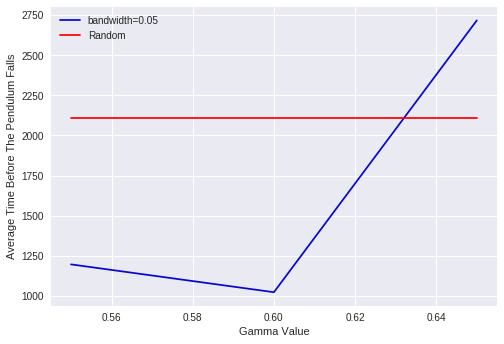

In [310]:
plt.close()
plt.figure()
bandwidth_set=np.array([0.05])
gamma_set=np.array([0.55,0.6,0.65])
random_plot_avg=np.zeros([1,gamma_set.size])+avg_steps_Acro
number_iterations=20

for i in range(bandwidth_set.size):
  average_test_run=np.zeros(gamma_set.size)
  for j in range (gamma_set.size):
    O,J=data_manipulation(bandwidth_set[i],gamma_set[j],number_iterations,data_tensor_Acro,R_Acro)
    average_test_run[j]=test_Acrobot(O,J,R_Acro,data_tensor_Acro,gamma_set[j],bandwidth_set[i],10)
  plt.plot(gamma_set.flatten(),average_test_run.flatten(),label="bandwidth={}".format(bandwidth_set[i]),color=(random.random(),random.random(),random.random()))
plt.plot(gamma_set.flatten(),random_plot_avg.flatten(),label="Random",color=(1,0,0))  
plt.legend()
plt.xlabel('Gamma Value')
plt.ylabel('Average Time Before The Pendulum Falls')
plt.show()


#### 2.2.3 Conclusion
We have discussed much of the limitations we faced in the section called "Results of the Algorithm for Acrobot Problem", so we will keep our conclusion short.

The above graph demonstrates how well the algorithm is perferming for diferent $(gamma)$ values and $(bandwidth)$ value of $0.05$ as we experimentally found it to be optimal for most $(gamma)$ values, and our limited computational resources would have not allowed for more $(bandwidth)$ values to be included in the graph. Here we can see that the $(gamma)$ of $0.6$ performs well, although we did achieve much better performance with higher observed data.

We observed that by increasing the number of sample transition per action, while taking random actions, to $10000$ the algorithm's performance increases drastically, but note that the amount of computations it would have required us to make the above graph would have been out of our computational resources.

A better approach perhaps, would have been sampling the space with an algorithm cable of reaching the objective state. That would have allowed us to decrease the number of needed samples.

In conclusion we would like to one more time mention that this task was much more complex in comparison to the first task we tackled. The complexity of the task makes random sampling/observation of the environment very ineffective leading to less effective algorithm.
